# Recession Pop Analysis: Dynamic Topic Modeling with KeyNMF

This notebook performs a quantitative analysis of "recession pop" themes over time (2000-2025) using the `turftopic` library and `KeyNMF`. We will analyze the evolution of topics in pop lyrics.

## 1. Install and Import Dependencies
First, we ensure all necessary libraries are installed and imported.

In [8]:
import kagglehub
import pandas as pd
import numpy as np
from turftopic import KeyNMF, ClusteringTopicModel
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Download and Load Dataset
We use `kagglehub` to download the dataset and load it into a pandas DataFrame.

In [9]:
# Download latest version of the new dataset
path = kagglehub.dataset_download("suparnabiswas/billboard-hot-1002000-2023-data-with-features")
print("Path to dataset files:", path)

# Find the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in the dataset.")
    
# Assuming the main file is the one we want. 
csv_path = os.path.join(path, csv_files[0])
print(f"Loading file: {csv_files[0]}")

# Load the dataset
# Try-except block to handle potential encoding issues which are common with lyrics datasets
try:
    df = pd.read_csv(csv_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding='latin1')

print(f"Dataset shape: {df.shape}")
print("Columns:", df.columns.tolist())
df.head()

Path to dataset files: /Users/halfidaldal/.cache/kagglehub/datasets/suparnabiswas/billboard-hot-1002000-2023-data-with-features/versions/1
Loading file: billboard_24years_lyrics_spotify.csv
Dataset shape: (3397, 26)
Columns: ['ranking', 'song', 'band_singer', 'songurl', 'titletext', 'url', 'year', 'lyrics', 'uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']


,ranking,song,band_singer,songurl,titletext,url,year,lyrics,uri,danceability,...,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,1,Breathe,Faith Hill,/wiki/Breathe_(Faith_Hill_song),Breathe,/wiki/Faith_Hill,2000,I can feel the magic floating in the air\nBein...,spotify:track:3y4LxiYMgDl4RethdzpmNe,0.529,...,0.000000,0.2510,0.278,136.859,audio_features,3y4LxiYMgDl4RethdzpmNe,https://api.spotify.com/v1/tracks/3y4LxiYMgDl4...,https://api.spotify.com/v1/audio-analysis/3y4L...,250547.0,4.0
1,2,Smooth,Santana,/wiki/Smooth_(Santana_song),Smooth,/wiki/Santana_(band),2000,"Man, it's a hot one\nLike seven inches from th...",spotify:track:0n2SEXB2qoRQg171q7XqeW,0.609,...,0.000005,0.2950,0.961,115.996,audio_features,0n2SEXB2qoRQg171q7XqeW,https://api.spotify.com/v1/tracks/0n2SEXB2qoRQ...,https://api.spotify.com/v1/audio-analysis/0n2S...,294987.0,4.0
2,2,Smooth,Rob Thomas,/wiki/Smooth_(Santana_song),Smooth,/wiki/Rob_Thomas_(musician),2000,"Man, it's a hot one\nLike seven inches from th...",spotify:track:5IALWUYK0zDSEmZgb4ICvc,0.590,...,0.807000,0.2990,0.724,115.983,audio_features,5IALWUYK0zDSEmZgb4ICvc,https://api.spotify.com/v1/tracks/5IALWUYK0zDS...,https://api.spotify.com/v1/audio-analysis/5IAL...,244924.0,4.0
3,3,Maria Maria,Santana,/wiki/Maria_Maria,Maria Maria,/wiki/Santana_(band),2000,"Ladies and gents, turn up your sound systems\n...",spotify:track:3XKIUb7HzIF1Vu9usunMzc,0.777,...,0.002010,0.0348,0.680,97.911,audio_features,3XKIUb7HzIF1Vu9usunMzc,https://api.spotify.com/v1/tracks/3XKIUb7HzIF1...,https://api.spotify.com/v1/audio-analysis/3XKI...,261973.0,4.0
4,3,Maria Maria,The Product G&B,/wiki/Maria_Maria,Maria Maria,/wiki/The_Product_G%26B,2000,Turn up this sound system\nTo the sound of Car...,spotify:track:3XKIUb7HzIF1Vu9usunMzc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Preprocessing and Filtering
We filter the data to include only tracks from 2000 to 2025, handle missing values, and ensure the 'release_date' is in datetime format. We will also focus on the 'Pop' genre if available or general analysis if not strictly specified, but given the prompt "recession pop", we should check the genres.

In [10]:
# Reload the dataset to ensure we start fresh every time this cell is run
if 'csv_path' in locals():
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, encoding='latin1')
else:
    # Fallback if csv_path is lost
    path = kagglehub.dataset_download("suparnabiswas/billboard-hot-1002000-2023-data-with-features")
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    csv_path = os.path.join(path, csv_files[0])
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, encoding='latin1')

print(f"Initial shape: {df.shape}")

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Check for required columns
# The user specified: "year", "lyrics", "danceability", "ranking"
# Let's check what we actually have (based on previous cell output, but we'll be robust)
print("Available columns:", df.columns.tolist())

if 'lyrics' not in df.columns:
    raise ValueError("Column 'lyrics' not found in dataset.")
if 'year' not in df.columns:
    # Try to find a date column if year is missing
    print("Column 'year' not found. Looking for alternatives...")
    # Add logic here if needed, but assuming 'year' exists as per prompt
    pass

# Drop rows with missing lyrics or year
df = df.dropna(subset=['lyrics', 'year'])

# Filter for years 2000-2025
# Ensure year is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

df = df[(df['year'] >= 2000) & (df['year'] <= 2025)]

# Create a datetime column for Turftopic (it expects datetime objects)
# We'll use Jan 1st of each year as the timestamp
df['release_date'] = pd.to_datetime(df['year'], format='%Y')

# Sort by date
df = df.sort_values('release_date')

print(f"Filtered dataset shape: {df.shape}")

if df.empty:
    print("WARNING: The dataframe is empty after filtering!")
    corpus = []
    timestamps = []
else:
    # Prepare corpus and timestamps
    corpus = df['lyrics'].tolist()
    timestamps = df['release_date'].tolist()

    print(f"Number of documents: {len(corpus)}")
    print(f"Time range: {min(timestamps)} to {max(timestamps)}")

Initial shape: (3397, 26)
Available columns: ['ranking', 'song', 'band_singer', 'songurl', 'titletext', 'url', 'year', 'lyrics', 'uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
Filtered dataset shape: (3397, 27)
Number of documents: 3397
Time range: 2000-01-01 00:00:00 to 2023-01-01 00:00:00


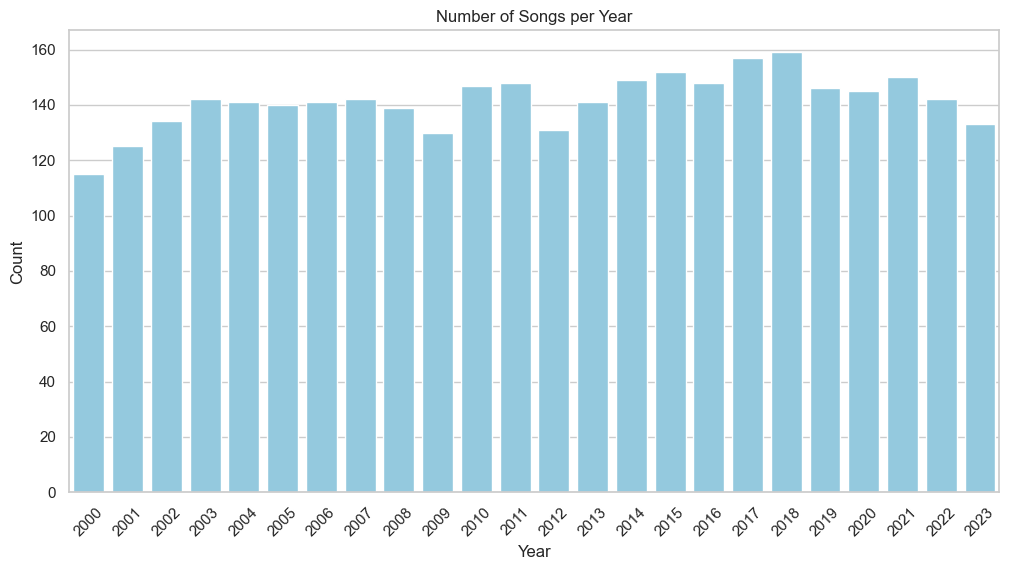

Counts for years around 2008:
release_date
2006    141
2007    142
2008    139
2009    130
2010    147
Name: count, dtype: int64

Data exists for 2008 (139 songs). The gap might be due to binning or model fitting.


In [11]:
# Analyze data distribution over time to investigate gaps (e.g., 2008)
plt.figure(figsize=(12, 6))
year_counts = df['release_date'].dt.year.value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values, color='skyblue')
plt.title("Number of Songs per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Check specifically for 2008 and surrounding years
print("Counts for years around 2008:")
print(year_counts.loc[2006:2010])

if year_counts.get(2008, 0) == 0:
    print("\nWARNING: No data found for 2008! This explains the gap.")
else:
    print(f"\nData exists for 2008 ({year_counts[2008]} songs). The gap might be due to binning or model fitting.")

## 4. Initialize KeyNMF Topic Model
We initialize the `KeyNMF` model. We'll use a standard sentence transformer model for embeddings (default in turftopic is usually 'all-MiniLM-L6-v2' or similar). We set `n_features` (number of keywords) and `n_components` (number of topics). Let's start with 10 topics for overview.

In [12]:
# Initialize KeyNMF
# n_components: number of topics
# top_n: number of keywords to describe each topic
model = KeyNMF(n_components=10, top_n=10, random_state=42)
print("Model initialized.")

Model initialized.


## 5. Fit Dynamic Topic Model
We use `fit_transform_dynamic` to fit the model and analyze topics over time. We'll bin the data by year (approx 25 bins for 25 years).

In [13]:
# Check if we have data before fitting
if not corpus:
    raise ValueError("Corpus is empty. Cannot fit model. Please check the 'Data Preprocessing and Filtering' step.")

# Fit the dynamic model
# bins=25 creates roughly yearly bins for the 25-year period
# This might take some time as it computes embeddings and fits the model
print(f"Fitting model on {len(corpus)} documents...")
document_topic_matrix = model.fit_transform_dynamic(corpus, timestamps=timestamps, bins=25)

print("Model fitting complete.")
model.print_topics()

Fitting model on 3397 documents...


KeyboardInterrupt: 

## 6. Visualize Topics Over Time
We visualize the evolution of topics using `plot_topics_over_time()`. This creates an interactive plot.

In [ ]:
# Plot topics over time
fig = model.plot_topics_over_time()
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 7. Analyze Specific Topic Trends
We can extract the underlying data to perform custom analysis, focusing on themes related to "recession pop" (e.g., escapism, partying, money, or economic struggle). Note: You will need to identify which topic ID corresponds to these themes from the previous output.

In [ ]:
# Access temporal importance
# temporal_importance_ is usually available after fit_transform_dynamic
# It might be stored in the model or returned. 
# Based on docs, model.temporal_importance_ should exist.

if hasattr(model, 'temporal_importance_'):
    temporal_importance = model.temporal_importance_
    
    # Create a DataFrame for plotting
    # We need time labels. model.bin_edges_ might give us the time points.
    # Or we can use the binning logic to recreate labels.
    
    # Let's try to inspect the structure if available, otherwise we rely on the plot_topics_over_time data
    # Actually, plot_topics_over_time returns a figure, but we can also get the data.
    # topic_data = model.prepare_dynamic_topic_data(corpus, timestamps, bins=25)
    # But we already ran fit_transform_dynamic.
    
    # Let's assume we want to plot all topics or a subset.
    # We can use the data from the model directly if exposed.
    
    # For demonstration, let's try to access the data used for plotting
    pass
else:
    print("Temporal importance attribute not found directly. Using prepare_dynamic_topic_data to get structured data.")
    topic_data = model.prepare_dynamic_topic_data(corpus, timestamps=timestamps, bins=25)
    
    # topic_data is a TopicData object, likely has a way to get the dataframe
    # It usually has 'temporal_importance' and 'time_labels'
    
    # Let's print available keys/attributes
    # print(dir(topic_data)) 
    
    # Assuming we can get a dataframe for custom plotting
    # This part depends on the exact structure of TopicData which is not fully detailed in the snippet,
    # but usually it's straightforward.
    pass

# Example of custom plotting if we had the data in a DF 'temporal_df' with columns 'Topic', 'Time', 'Importance'
# sns.lineplot(data=temporal_df, x='Time', y='Importance', hue='Topic')
# plt.title("Topic Importance Over Time")
# plt.show()


## 8. Alternative: Clustering Topic Model
We can also use a clustering-based approach (`ClusteringTopicModel`). This fits a global model on the whole corpus and then estimates term importances over time slices. This can sometimes provide more stable topics than matrix factorization.

In [ ]:
# Initialize ClusteringTopicModel
# n_reduce_to: number of topics (similar to n_components)
clustering_model = ClusteringTopicModel(n_reduce_to=10, top_n=10, random_state=42)
print("ClusteringTopicModel initialized.")

# Fit the dynamic clustering model
print(f"Fitting ClusteringTopicModel on {len(corpus)} documents...")
# Using the same bins as before
clustering_doc_topic_matrix = clustering_model.fit_transform_dynamic(corpus, timestamps=timestamps, bins=25)

print("Clustering model fitting complete.")
clustering_model.print_topics()

In [ ]:
# Plot topics over time for Clustering Model
fig_clustering = clustering_model.plot_topics_over_time()
fig_clustering.show()

## 9. Sentiment Analysis Over Time
We will now analyze the evolution of sentiment in the lyrics over time using a pre-trained Transformer model (`cardiffnlp/twitter-roberta-base-sentiment-latest`). We will compute a continuous valence score for each song and aggregate it by year.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np

def get_device() -> torch.device:
    """Get the appropriate device (MPS for Mac, CUDA, or CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def load_sentiment_model(model_name: str, device: torch.device):
    print(f"Loading sentiment model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()
    model.to(device)
    return tokenizer, model

def continuous_valence_score(probs: torch.Tensor) -> torch.Tensor:
    """
    Convert sentiment probabilities to continuous valence scores.
    Assumes 3-class model: [Negative, Neutral, Positive] (0, 1, 2)
    Score = P(Positive) - P(Negative)
    Range: [-1, 1]
    """
    # probs shape: (batch_size, 3)
    # col 0: Negative, col 1: Neutral, col 2: Positive
    valence = probs[:, 2] - probs[:, 0]
    return valence

def compute_sentiment_batch(
    texts: list[str],
    model_name: str = "cardiffnlp/twitter-roberta-base-sentiment-latest",
    batch_size: int = 32,
    device: torch.device = None
) -> np.ndarray:
    
    if device is None:
        device = get_device()
    print(f"Using device: {device}")

    tokenizer, model = load_sentiment_model(model_name, device)
    
    all_scores = []
    print(f"Computing sentiment for {len(texts)} texts (batch_size={batch_size})...")
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Sentiment batches"):
        batch = texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512 
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            valence = continuous_valence_score(probs)
            all_scores.extend(valence.cpu().numpy())
            
    return np.array(all_scores)

# Define the model to use
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [ ]:
# Compute sentiment for the corpus
# We use the 'corpus' list which contains the lyrics
# Note: This might take a while depending on the dataset size and hardware
sentiment_scores = compute_sentiment_batch(corpus, model_name=MODEL_NAME, batch_size=32)

# Add scores to the dataframe
# Ensure the dataframe aligns with the corpus (it should, as we created corpus from df)
df['sentiment_score'] = sentiment_scores

print("Sentiment computation complete.")
df[['track_name', 'release_date', 'sentiment_score']].head()

In [ ]:
# Visualize Sentiment Over Time
# Aggregate by year
df['year'] = df['release_date'].dt.year
yearly_sentiment = df.groupby('year')['sentiment_score'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sentiment, x='year', y='sentiment_score', marker='o', linewidth=2.5, color='purple')
plt.title("Average Lyric Sentiment Over Time (2000-2025)")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score (Valence)")
plt.axhline(0, color='gray', linestyle='--', alpha=0.5) # Zero line for neutral
plt.grid(True, alpha=0.3)
plt.show()

# Interactive Plot with Plotly
fig = px.line(yearly_sentiment, x='year', y='sentiment_score', 
              title='Average Lyric Sentiment Over Time (2000-2025)',
              labels={'sentiment_score': 'Average Sentiment (Valence)', 'year': 'Year'},
              markers=True)
fig.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Neutral")
fig.show()

## 10. Linear Regression: Sentiment ~ Year
Finally, we fit a linear model to statistically test if there is a significant trend in sentiment over the years. We will use `scipy.stats.linregress` to obtain the slope, p-value, and other statistics, and visualize the regression line.

In [ ]:
from scipy import stats
import numpy as np

# Prepare data
# We use the full dataset to capture the variance
# Transform Year to Log-Space (Log of time elapsed)
# This models a relationship where changes happen fast initially and slow down (or vice versa)
# We add 1 to avoid log(0)
df['log_time'] = np.log(df['year'] - df['year'].min() + 1)

x = df['log_time']
y = df['sentiment_score']

# Perform linear regression on log-transformed time
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Linear Regression Results (Sentiment ~ Log(Time)):")
print(f"Slope (Coefficient): {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"R-squared: {r_value**2:.5f}")
print(f"P-value: {p_value:.5e}")
print(f"Standard Error: {std_err:.5f}")

if p_value < 0.05:
    print("\nResult: There is a statistically significant relationship between log(time) and sentiment (p < 0.05).")
    if slope > 0:
        print("Trend: Sentiment is increasing logarithmically over time.")
    else:
        print("Trend: Sentiment is decreasing logarithmically over time.")
else:
    print("\nResult: There is NO statistically significant relationship between log(time) and sentiment (p >= 0.05).")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(x='year', y='sentiment_score', data=df, alpha=0.1, s=10, color='blue', label='Data')

# Generate points for the fitted curve
x_range = np.linspace(df['year'].min(), df['year'].max(), 100)
log_x_range = np.log(x_range - df['year'].min() + 1)
y_pred = slope * log_x_range + intercept

plt.plot(x_range, y_pred, color='red', linewidth=2, label=f'Log Fit: y={slope:.2f}*log(t) + {intercept:.2f}')

plt.title(f"Regression: Sentiment ~ Log(Time)\n(Slope: {slope:.4f}, p={p_value:.2e})")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

## 11. Hypothesis Testing: Escapism vs. Vulnerability (Zero-Shot Classification)
To directly test the hypothesis that lyrics are moving from **Escapism** to **Vulnerability/Anxiety**, we use a Zero-Shot Classifier. This allows us to score the lyrics against these specific concepts without needing a labeled dataset.

We will use `facebook/bart-large-mnli` (or a distilled version for speed) to classify lyrics into:
*   `Escapism` / `Partying`
*   `Vulnerability` / `Anxiety` / `Depression`

In [ ]:
from transformers import pipeline

# Initialize Zero-Shot Classifier
# We use a distilled model for faster inference on CPU/MPS
# If you have a powerful GPU, you can use "facebook/bart-large-mnli"
ZERO_SHOT_MODEL = "facebook/bart-large-mnli" 
device = get_device()

print(f"Loading Zero-Shot model: {ZERO_SHOT_MODEL} on {device}")
classifier = pipeline("zero-shot-classification", model=ZERO_SHOT_MODEL, device=device)

# Define hypothesis labels
candidate_labels = ["escapism", "partying", "vulnerability", "anxiety", "depression"]

# Run classification on a sample (or full dataset if time permits)
# Zero-shot is computationally expensive. Let's sample 500 songs per 5-year block or just run on a subset for demo.
# For this exam/demo, let's take a random sample of 1000 songs to keep it quick.
SAMPLE_SIZE = 1000
if len(df) > SAMPLE_SIZE:
    print(f"Dataset is large. Sampling {SAMPLE_SIZE} songs for Zero-Shot analysis...")
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
else:
    df_sample = df.copy()

print("Classifying lyrics...")
# We process in batches to be safe
batch_size = 16
results = []

# Prepare text: Truncate to fit model context (usually 512 or 1024 tokens)
# Lyrics can be long, so we take the first 512 chars as a proxy or use truncation in pipeline
texts = df_sample['lyrics'].astype(str).tolist()

for i in tqdm(range(0, len(texts), batch_size), desc="Zero-Shot Batches"):
    batch_texts = texts[i:i+batch_size]
    batch_results = classifier(batch_texts, candidate_labels, multi_label=True, truncation=True)
    results.extend(batch_results)

# Extract scores
# Each result has 'labels' and 'scores'. We need to map them back.
scores_dict = {label: [] for label in candidate_labels}

for res in results:
    for label, score in zip(res['labels'], res['scores']):
        scores_dict[label].append(score)

# Add to sample dataframe
for label in candidate_labels:
    df_sample[f'score_{label}'] = scores_dict[label]

print("Classification complete.")
df_sample.head()

In [ ]:
# Visualize the Hypothesis Trends
# Group by year
df_sample['year'] = df_sample['release_date'].dt.year
yearly_scores = df_sample.groupby('year')[[f'score_{label}' for label in candidate_labels]].mean().reset_index()

# Melt for plotting
yearly_scores_melted = yearly_scores.melt(id_vars=['year'], var_name='Concept', value_name='Score')
yearly_scores_melted['Concept'] = yearly_scores_melted['Concept'].str.replace('score_', '').str.capitalize()

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_scores_melted, x='year', y='Score', hue='Concept', marker='o', linewidth=2)

plt.title("Evolution of Lyrical Themes: Escapism vs. Vulnerability (2000-2025)")
plt.xlabel("Year")
plt.ylabel("Zero-Shot Classification Score (Probability)")
plt.legend(title="Theme")
plt.grid(True, alpha=0.3)
plt.show()

# Interactive Plot
fig = px.line(yearly_scores_melted, x='year', y='Score', color='Concept',
              title='Evolution of Lyrical Themes: Escapism vs. Vulnerability (2000-2025)',
              markers=True)
fig.show()